In [1]:
import math as math
# Load libraries
import random
from itertools import batched
import sympy as sp

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fontTools.misc.timeTools import epoch_diff

In [2]:
# Read data
data = np.loadtxt('data/ex2data1.txt', delimiter=',')
np.random.shuffle(data)
X = data[:, :-1]
Y = data[:, -1, np.newaxis]
print(X.shape, Y.shape)
print(data)

(100, 2) (100, 1)
[[40.45755098 97.53518549  1.        ]
 [54.63510555 52.21388588  0.        ]
 [30.28671077 43.89499752  0.        ]
 [45.08327748 56.31637178  0.        ]
 [62.27101367 69.95445795  1.        ]
 [74.24869137 69.82457123  1.        ]
 [85.40451939 57.05198398  1.        ]
 [71.79646206 78.45356225  1.        ]
 [79.94481794 74.16311935  1.        ]
 [89.84580671 45.35828361  1.        ]
 [82.36875376 40.61825516  0.        ]
 [75.39561147 85.75993667  1.        ]
 [79.03273605 75.34437644  1.        ]
 [56.2538175  39.26147251  0.        ]
 [99.8278578  72.36925193  1.        ]
 [50.28649612 49.80453881  0.        ]
 [97.77159928 86.72782233  1.        ]
 [33.91550011 98.86943574  0.        ]
 [57.23870632 59.51428198  1.        ]
 [35.84740877 72.90219803  0.        ]
 [83.48916274 48.3802858   1.        ]
 [80.366756   90.9601479   1.        ]
 [70.66150955 92.92713789  1.        ]
 [42.26170081 87.10385094  1.        ]
 [34.52451385 60.39634246  0.        ]
 [52.10

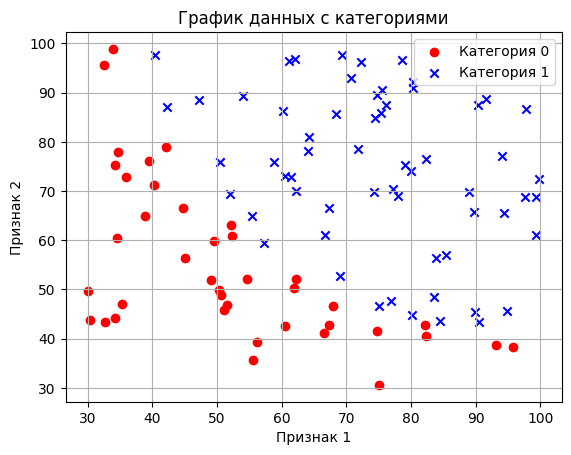

In [3]:
def plot_data(data):
    x1 = data[:, 0]
    x2 = data[:, 1]
    y = data[:, 2]

    #plt.figure(figsize=(8,6))
    plt.scatter(x1[y == 0], x2[y == 0], color='red', label='Категория 0', marker='o')
    plt.scatter(x1[y == 1], x2[y == 1], color='blue', label='Категория 1', marker='x')

    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.title('График данных с категориями')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_data(data)



In [4]:
# Standardize data
def standardize_data(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    return (data - means) / stds, means, stds


X_standard, means, stds = standardize_data(X)

In [5]:
# Split data
def split_data(x_data, y_data):
    train_size = int(x_data.shape[0] * 0.5)
    x_train, x_validate = x_data[:train_size], x_data[train_size:]
    y_train, y_validate = y_data[:train_size], y_data[train_size:]
    return x_train, y_train, x_validate, y_validate


# Add x0
ones_column = np.ones((X_standard.shape[0], 1))
X_with_ones = np.hstack((ones_column, X_standard))
X_train, y_train, X_validate, y_validate = split_data(X_with_ones, Y)
print(X_train.shape, y_train.shape)
print(X_train)

(50, 3) (50, 1)
[[ 1.         -1.30092096  1.69355351]
 [ 1.         -0.56863523 -0.7576197 ]
 [ 1.         -1.82625564 -1.2075414 ]
 [ 1.         -1.06199728 -0.5357394 ]
 [ 1.         -0.17423248  0.20186768]
 [ 1.          0.44442728  0.19484284]
 [ 1.          1.02063763 -0.49595429]
 [ 1.          0.31776703  0.66153625]
 [ 1.          0.73863826  0.42949041]
 [ 1.          1.25003483 -1.12840052]
 [ 1.          0.86383711 -1.38476189]
 [ 1.          0.50366692  1.05669679]
 [ 1.          0.69152826  0.49337794]
 [ 1.         -0.48502704 -1.45814261]
 [ 1.          1.76561835  0.33247025]
 [ 1.         -0.79324552 -0.88792768]
 [ 1.          1.65941042  1.10904426]
 [ 1.         -1.63882482  1.76571557]
 [ 1.         -0.43415649 -0.36278249]
 [ 1.         -1.53903969  0.3612943 ]
 [ 1.          0.92170742 -0.96495748]
 [ 1.          0.76043181  1.33794685]
 [ 1.          0.25914553  1.44433023]
 [ 1.         -1.2077347   1.12938152]
 [ 1.         -1.60736862 -0.31507682]
 [ 1.    

In [22]:
def draw_errors(train_error_array, validate_error_array, alpha):
    epochs = np.arange(1, len(train_error_array) + 1)

    plt.plot(epochs, train_error_array, label='Train Error', color='blue', linewidth=2)

    plt.plot(epochs, validate_error_array, label='Validation Error', color='red', linewidth=2)

    plt.title(f'График ошибки с коэффициентом обучения {round(alpha, 8)}')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()

    plt.grid(True)
    plt.show()

def draw_accuracy(train_accuracy_array, validate_accuracy_array, alpha):
    epochs = np.arange(1, len(train_accuracy_array) + 1)
    print("epochs:", len(epochs))

    plt.plot(epochs, train_accuracy_array, label='Train Error', color='blue', linewidth=2)

    plt.plot(epochs, validate_accuracy_array, label='Validation Error', color='red', linewidth=2)

    plt.title(f'График точности обучения с коэффициентом {round(alpha, 8)}')
    plt.xlabel('Epoch')
    plt.ylabel('Фccuracy')
    plt.legend()

    plt.grid(True)
    plt.show()

def plot_data_with_function(data, teta, line_function):
    x1 = data[:, 0]
    x2 = data[:, 1]
    y = data[:, 2]

    try:
        x1S, x2S, expr = line_function(teta)
        x1_vals = np.linspace(min(x1), max(x1), 100)
        x1_vals_std = (x1_vals - means[0]) / stds[0]
        x2_vals_std = np.array([float(expr[0].subs(x1S, x_val)) for x_val in x1_vals_std])
        x2_vals = x2_vals_std * stds[1] + means[1]
        plt.plot(x1_vals, x2_vals, color='green', label='Линейная функция')
        print(expr[0].subs(x1S, 0))
    except:
        print("Не получилось построить график функции")
        return

    #plt.figure(figsize=(8,6))
    plt.scatter(x1[y == 0], x2[y == 0], color='red', label='Категория 0', marker='o')
    plt.scatter(x1[y == 1], x2[y == 1], color='blue', label='Категория 1', marker='x')

    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.title('График данных с категориями')
    plt.legend()
    plt.grid(True)
    plt.show()


def calculate_h(teta, x_matrix):
    v = x_matrix @ (teta.T)
    sigmoid = 1 / (1 + (math.e ** (-v)))
    return sigmoid


def calculate_teta_shift(h_array, x_matrix, y_array, spead: float):
    return spead * ((h_array - y_array).T @ x_matrix) / x_matrix.shape[0]


def calculate_error(x_matrix, y_array, teta):
    #return ((y_array - calculate_h(teta, x_matrix)) ** 2).sum() / x_matrix.shape[0]
    h = calculate_h(teta, x_matrix)
    one_column = np.ones((x_matrix.shape[0], 1))
    j = (y_array - one_column) * np.log(one_column - h) - y_array * np.log(h)
    return j.sum() / x_matrix.shape[0]


def calculate_accuracy(x_matrix, y_array, teta):
    h = calculate_h(teta, x_matrix)
    transformed_matrix = (h > 0.5).astype(int)
    result = (y_array == transformed_matrix).astype(int)
    return result.sum() / y_array.shape[0]


def learn_model(x_train_matrix, y_train_array, x_validate_matrix, y_validate_array, start_teta, epoch, learn,
                batch_size):
    teta = start_teta.copy()
    train_error_array = []
    validate_error_array = []
    train_accuracy_array = []
    validate_accuracy_array = []
    data_size = x_train_matrix.shape[0]
    for i in range(epoch):
        # shuffled data
        shuffled_indices = np.random.permutation(data_size)
        x_matrix_shuffled = x_train_matrix[shuffled_indices]
        y_array_shuffled = y_train_array[shuffled_indices]

        # calculate teta shift by minibatch
        for start_batch_index in range(0, data_size, batch_size):
            x_batch = x_matrix_shuffled[start_batch_index:min(start_batch_index + batch_size, data_size)]
            y_batch = y_array_shuffled[start_batch_index:min(start_batch_index + batch_size, data_size)]
            h_array = calculate_h(teta, x_batch)
            teta = teta - calculate_teta_shift(h_array, x_batch, y_batch, learn)

        train_error = calculate_error(x_train_matrix, y_train_array, teta)
        validate_error = calculate_error(x_validate_matrix, y_validate_array, teta)
        train_accuracy = calculate_accuracy(x_train_matrix, y_train_array, teta)
        validate_accuracy = calculate_accuracy(x_validate_matrix, y_validate_array, teta)
        #print("train error: ", train_error, " validation error: ", validate_error)
        train_error_array.append(train_error)
        validate_error_array.append(validate_error)
        train_accuracy_array.append(train_accuracy)
        validate_accuracy_array.append(validate_accuracy)

    return teta, train_error_array, validate_error_array, train_accuracy_array, validate_accuracy_array


def learn_model_with_any_superparameters(x_train, y_train, x_validate, y_validated, line_function):
    epoch_values = np.linspace(500, 5000, 3)
    learn_coefficients = np.linspace(0.01, 0.001, 2)
    # epoch_values = [400]
    # learn_coefficients = [0.01]
    for epoch in epoch_values:
        for learn_cof in learn_coefficients:
            start_teta = (np.random.randint(-12, 12, size=X_train.shape[1]))[np.newaxis, :]
            teta, train_error, validate_error, train_accuracy, validate_accuracy = learn_model(x_train, y_train,
                                                                                                x_validate, y_validated,
                                                                                                start_teta,
                                                                                                int(epoch), learn_cof,
                                                                                                8)
            plot_data_with_function(data, teta[0], line_function)
            draw_errors(train_error, validate_error, learn_cof)
            draw_accuracy(validate_accuracy, train_accuracy, learn_cof)

            print("Train error:", train_error[-1], "Validate error:", validate_error[-1])

-0.410602599482089


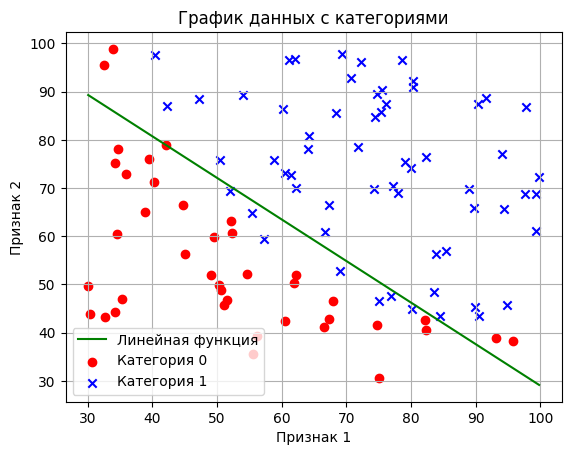

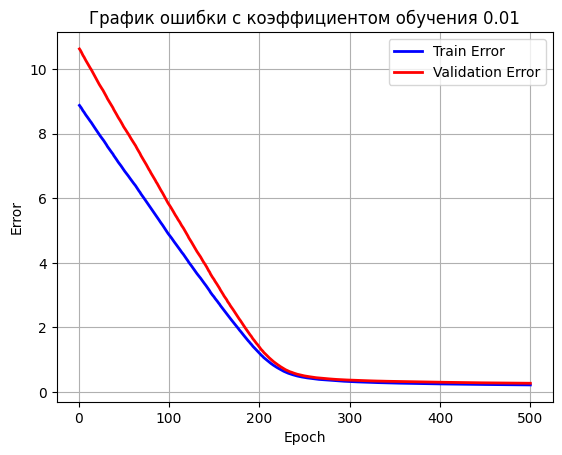

epochs: 500


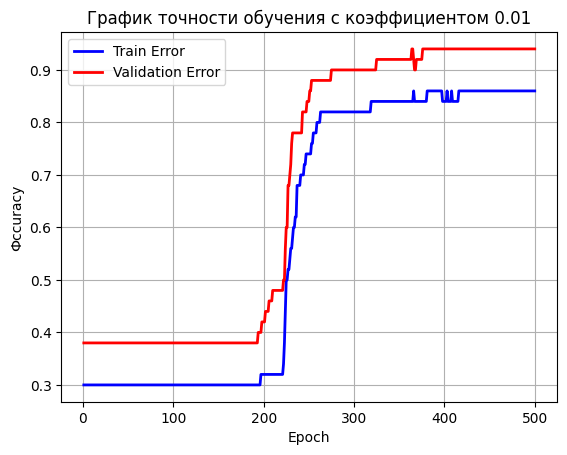

Train error: 0.22364617011953902 Validate error: 0.2750659575110736
0.308581364532388


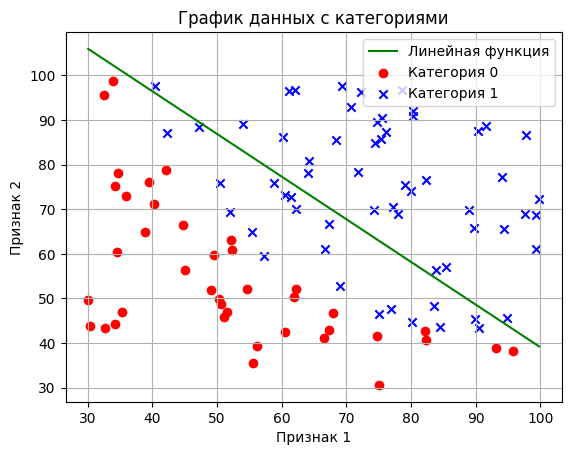

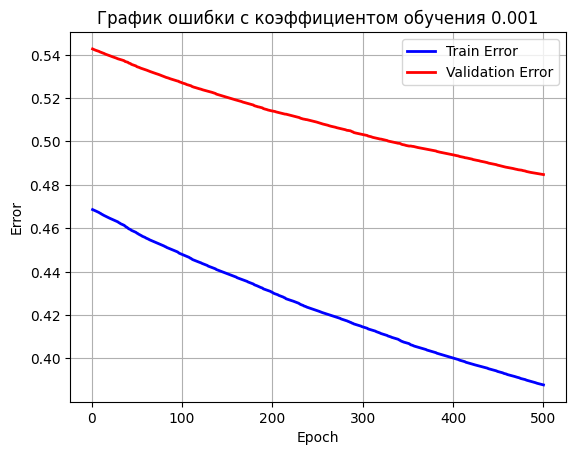

epochs: 500


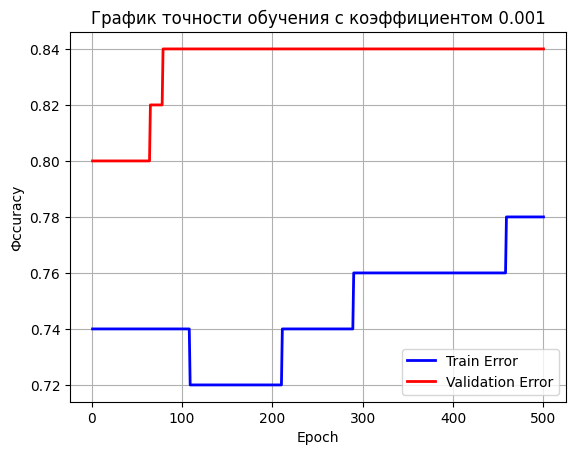

Train error: 0.3878193772831188 Validate error: 0.4847471196253679
-0.728907000517377


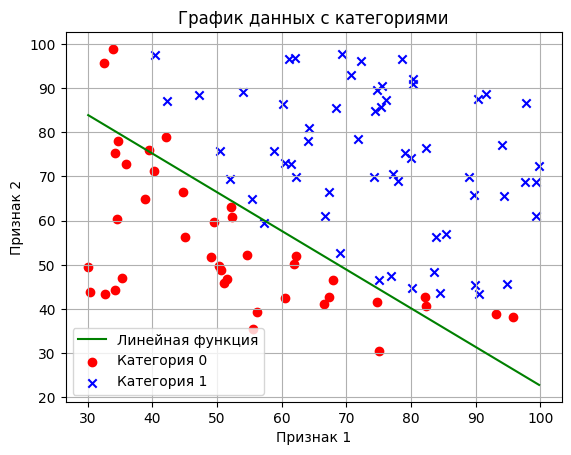

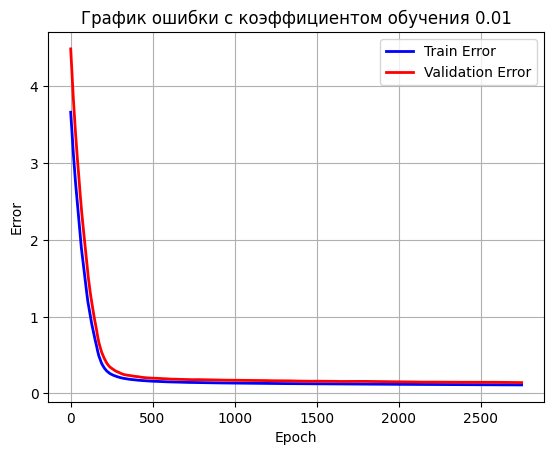

epochs: 2750


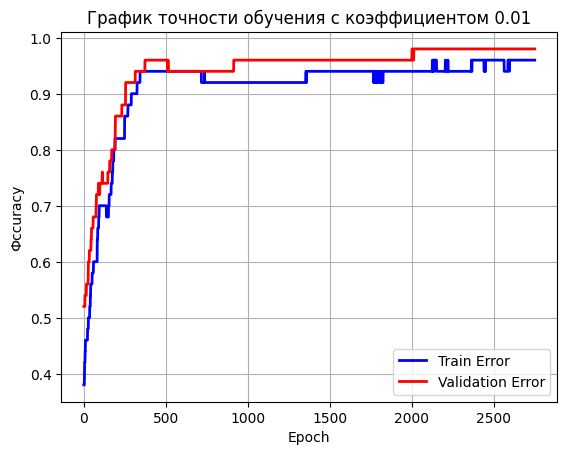

Train error: 0.10952594330031447 Validate error: 0.13995454503944238
-1.06368651475494


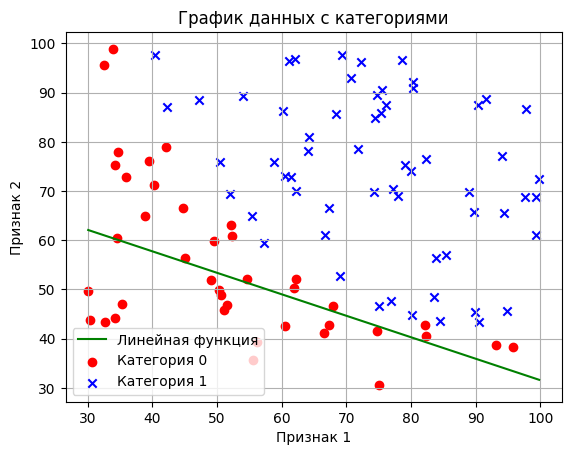

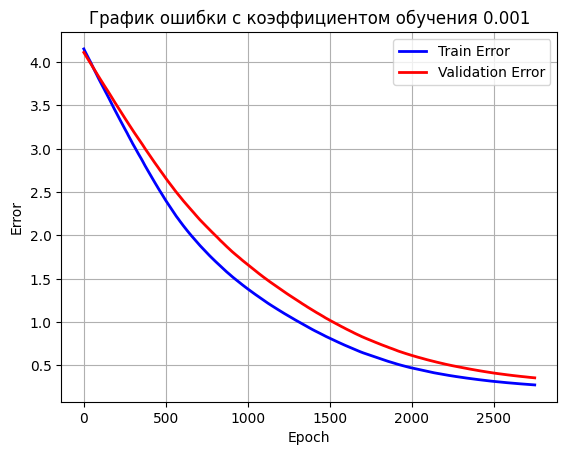

epochs: 2750


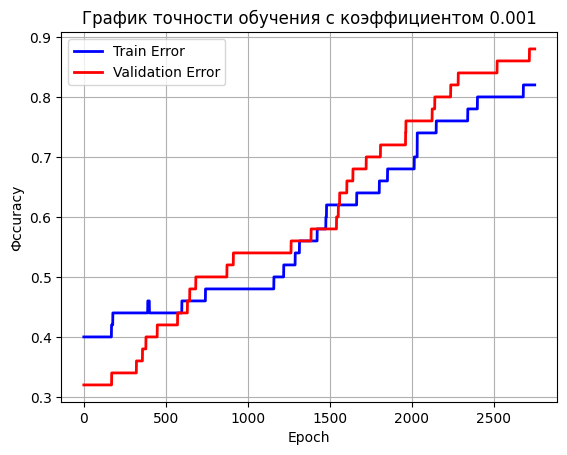

Train error: 0.271421383747829 Validate error: 0.3532965595738184
-0.851987377813150


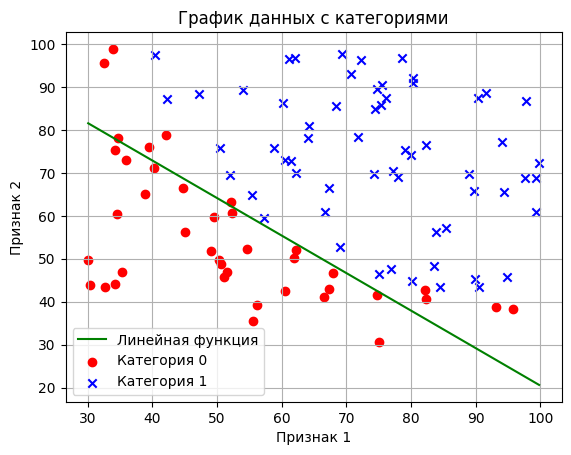

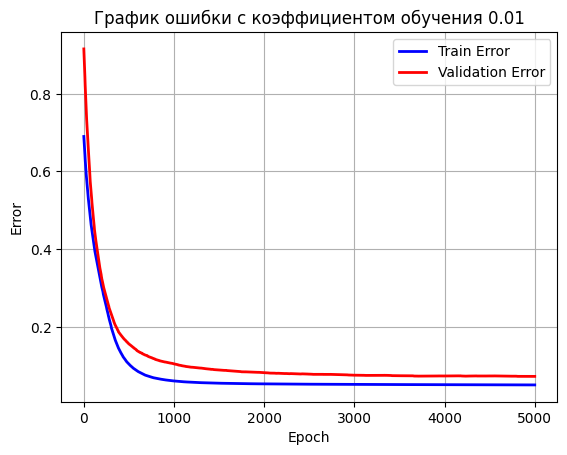

epochs: 5000


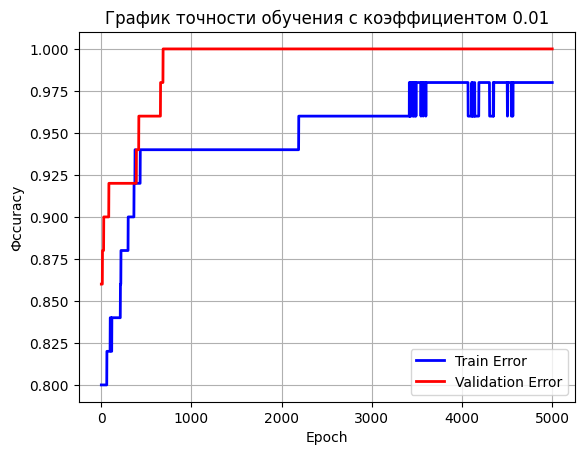

Train error: 0.04956515522813754 Validate error: 0.07157587718291823
0.760729681077403


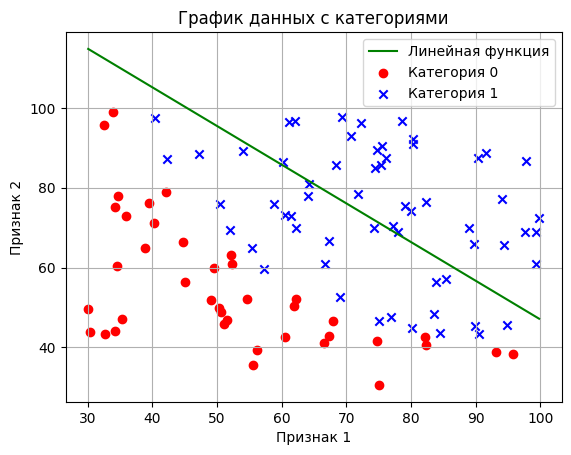

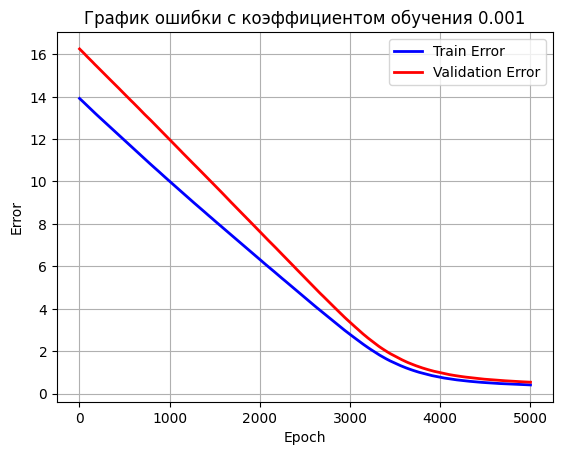

epochs: 5000


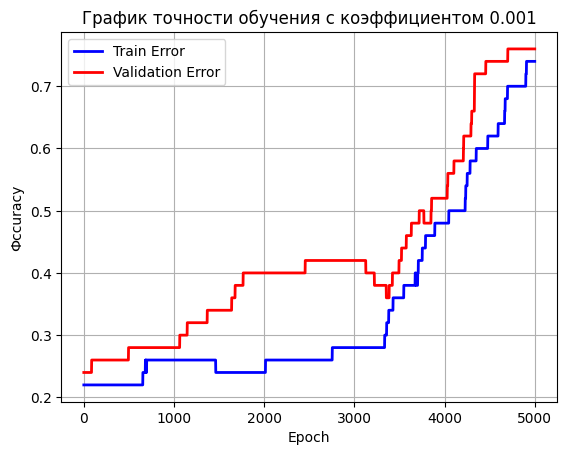

Train error: 0.4060146972195903 Validate error: 0.5346293233513996


In [23]:
def calc1(t):
    x1, x2 = sp.symbols('x1 x2')
    expression = t[0] + t[1] * x1 + t[2] * x2
    expr = sp.solve(expression, x2)
    return x1, x2, expr


learn_model_with_any_superparameters(X_train, y_train, X_validate, y_validate, calc1)

Добавим столбцы с расчётными значениями:
* x1 ^2

(100, 4) (100, 1)
0.0428233749498557


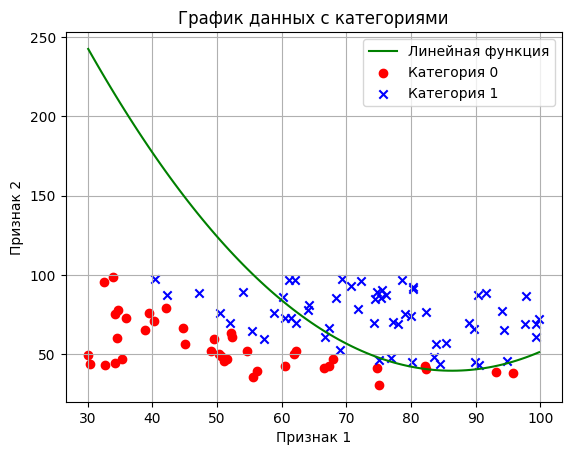

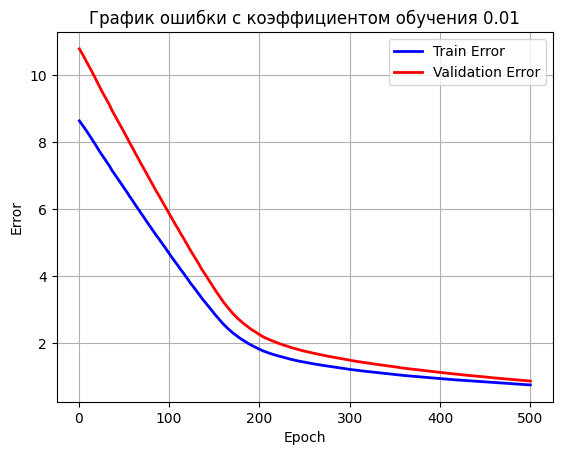

Train error: 0.7520317687494695 Validate error: 0.866872628418936
-1.66368552246293


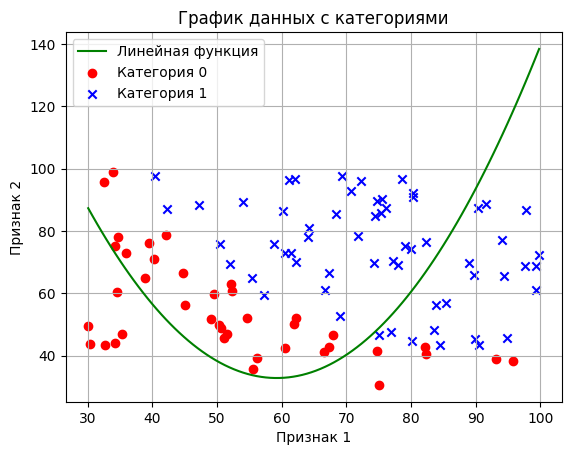

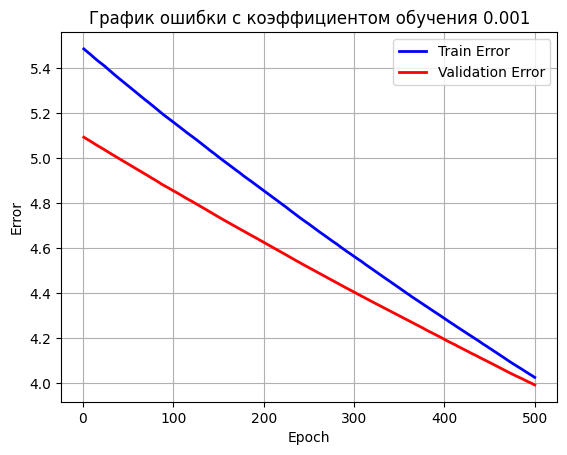

Train error: 4.024844310716995 Validate error: 3.991429624789947
-0.752973003977423


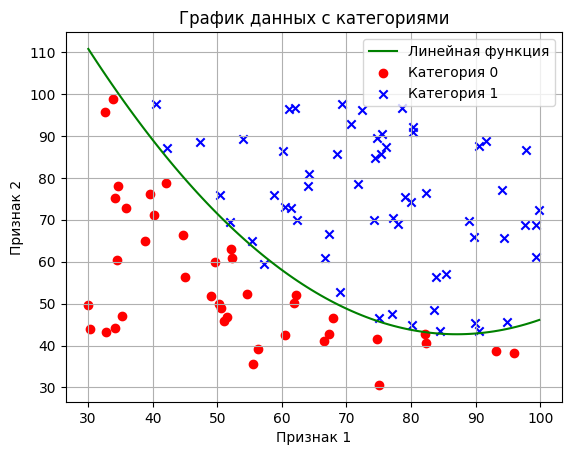

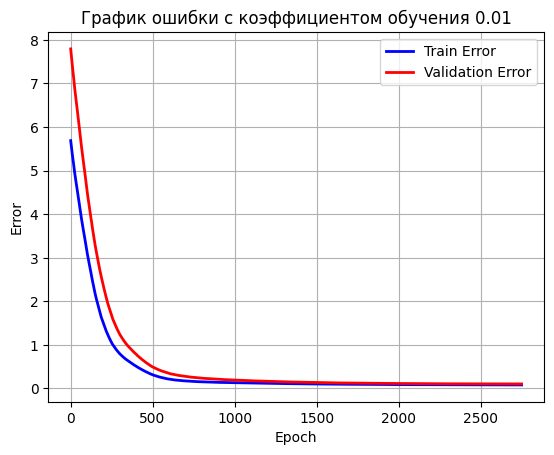

Train error: 0.08092719119777741 Validate error: 0.1033443535718435
2.96383844471902


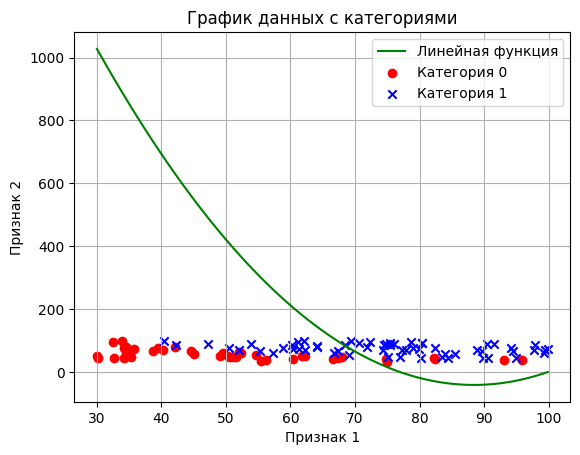

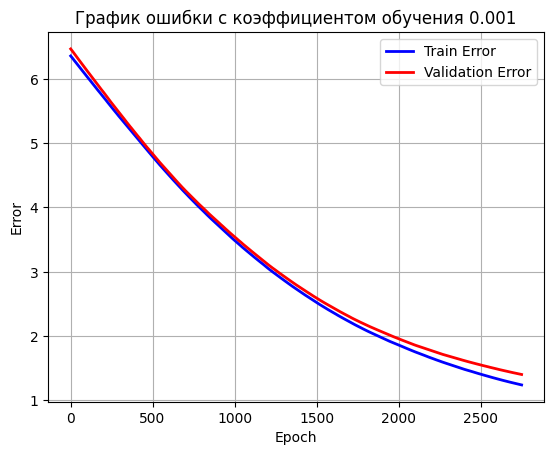

Train error: 1.237895582563042 Validate error: 1.4002183464001499


/tmp/ipykernel_19985/3360324562.py:65: RuntimeWarning: divide by zero encountered in log
  j = (y_array - one_column) * np.log(one_column - h) - y_array * np.log(h)
/tmp/ipykernel_19985/3360324562.py:65: RuntimeWarning: invalid value encountered in multiply
  j = (y_array - one_column) * np.log(one_column - h) - y_array * np.log(h)


-0.773301740841200


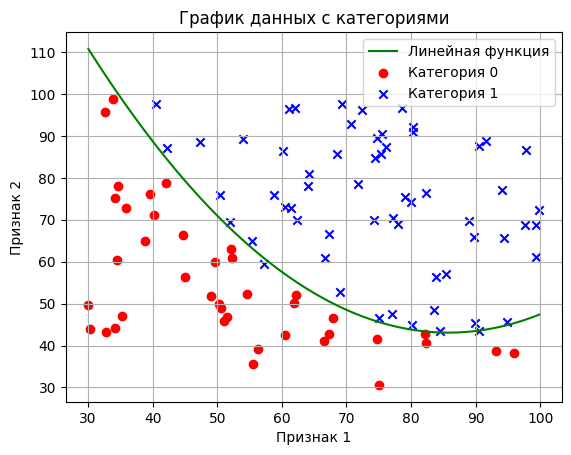

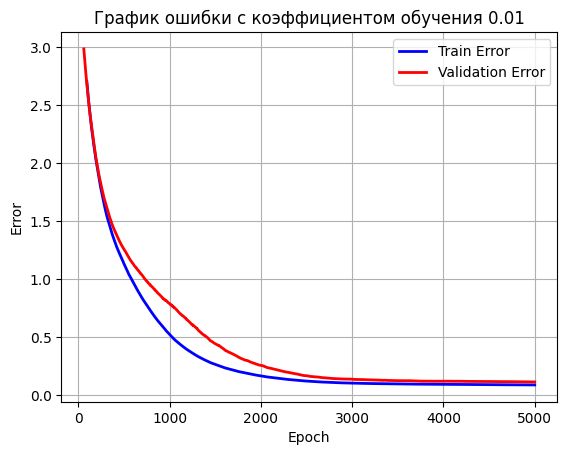

Train error: 0.09031703547273373 Validate error: 0.11597596347787195
-0.989590914453518


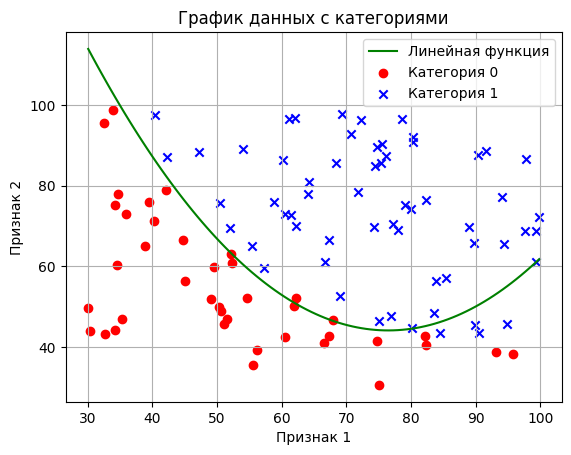

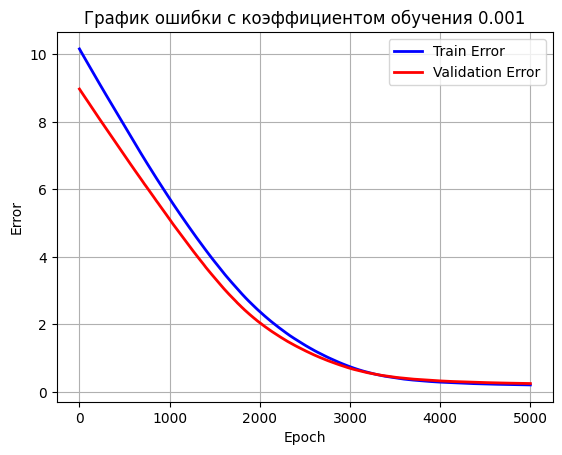

Train error: 0.20043547110593563 Validate error: 0.2418514154670837


In [8]:
X_extended = X_with_ones.copy()
X_extended = np.hstack((X_extended, (X_with_ones[:, 1] ** 2)[:, np.newaxis]))

print(X_extended.shape, Y.shape)
X_train, y_train, X_validate, y_validate = split_data(X_extended, Y)


def calc2(t):
    x1, x2 = sp.symbols('x1 x2')
    expression = t[0] + t[1] * x1 + t[2] * x2 + t[3] * (x1 ** 2)
    expr = sp.solve(expression, x2)
    return x1, x2, expr


learn_model_with_any_superparameters(X_train, y_train, X_validate, y_validate, calc2)